In [162]:
import nibabel as nib
import os
from nilearn import plotting as niplt
from nilearn import image as niimg
from nilearn.masking import apply_mask,unmask
import matplotlib.pyplot as plt
import pymp2rage
import nighres
from nilearn.datasets import fetch_icbm152_2009

In [163]:
froot = '/data01/lorenzo/PROJECTS/layers/data/'

sub = 1
ses = 1
t = 0

in_dir = froot + 'S{:02d}session{:d}/'.format(sub,ses)
out_dir = froot + 'S{:02d}session{:d}/brain_registration'.format(sub,ses)


# dataset = {'inv2'    : in_dir + 'S{:02d}_session{}_MP2RAGE_INV2_064mmL_10_1/S{:02d}_session{}_MP2RAGE_INV2_064mmL_10_1-t{:03d}.nii'.format(sub,ses,sub,ses,t),
# #                 't123'    : in_dir + 'S{:02d}_session{}_T123DEPI_08_INV2_16_1/S{:02d}_session{}_T123DEPI_08_INV2_16_1-t{:03d}-d0008.nii'.format(sub,ses,sub,ses,t)
#                }

In [164]:
mp2ragedata = {
                           'inv1' : in_dir + 'S{:02d}_session{}_MP2RAGE_INV1_064mmL_11_1/S{:02d}_session{}_MP2RAGE_INV1_064mmL_11_1-t000.nii'.format(sub,ses,sub,ses),
                           'inv1ph' : in_dir + 'S{:02d}_session{}_MP2RAGE_INV1_064mmL_11_1/S{:02d}_session{}_MP2RAGE_INV1_064mmL_11_1-t003.nii'.format(sub,ses,sub,ses),
                           'inv2' : in_dir + 'S{:02d}_session{}_MP2RAGE_INV2_064mmL_10_1/S{:02d}_session{}_MP2RAGE_INV2_064mmL_10_1-t000.nii'.format(sub,ses,sub,ses),
                           'inv2ph' : in_dir + 'S{:02d}_session{}_MP2RAGE_INV2_064mmL_10_1/S{:02d}_session{}_MP2RAGE_INV2_064mmL_10_1-t003.nii'.format(sub,ses,sub,ses)
                          
}
for f in mp2ragedata:
    print(os.path.isfile(mp2ragedata[f]))

True
True
True
True


In [165]:
ninv = 1
res = {1:11,2:10}
par_info = nib.parrec.parse_PAR_header(open('/data01/lorenzo/PROJECTS/layers/data/S01session1/S01_session1_MP2RAGE_INV{}_064mmL_{}_1.PAR'.format(ninv,res[ninv]),'r'))
nl = 120
image_info = {l:par_info[1][nl][i] for i,l in enumerate(par_info[1].dtype.names)}
print(image_info['image_flip_angle'])
print(image_info['Inversion delay'])
print(image_info['echo_time'])

7.0
0.0
2.24


In [166]:
fitter = pymp2rage.MP2RAGE(MPRAGE_tr=6.2,
                           invtimesAB=[0.67, 3.855],
                           flipangleABdegree=[7, 5],
                           nZslices=150,
                           FLASH_tr=[0.0062, 0.0320],
                           inv1=in_dir + 'S{:02d}_session{}_MP2RAGE_INV1_064mmL_11_1/S{:02d}_session{}_MP2RAGE_INV1_064mmL_11_1-t000.nii'.format(sub,ses,sub,ses),
                           inv1ph=in_dir + 'S{:02d}_session{}_MP2RAGE_INV1_064mmL_11_1/S{:02d}_session{}_MP2RAGE_INV1_064mmL_11_1-t003.nii'.format(sub,ses,sub,ses),
                           inv2=in_dir + 'S{:02d}_session{}_MP2RAGE_INV2_064mmL_10_1/S{:02d}_session{}_MP2RAGE_INV2_064mmL_10_1-t000.nii'.format(sub,ses,sub,ses),
                           inv2ph=in_dir + 'S{:02d}_session{}_MP2RAGE_INV2_064mmL_10_1/S{:02d}_session{}_MP2RAGE_INV2_064mmL_10_1-t003.nii'.format(sub,ses,sub,ses)
                          )


In [167]:
# t1map = fitter.t1map
t1w = fitter.t1w_uni


/home/deangelis/anaconda3/envs/nighres/lib/python3.7/site-packages/pymp2rage/mp2rage.py:163: RuntimeWarning: invalid value encountered in true_divide
  self._t1w_uni = (np.real(compINV1*compINV2/(compINV1**2 + compINV2**2)))*4095+2048


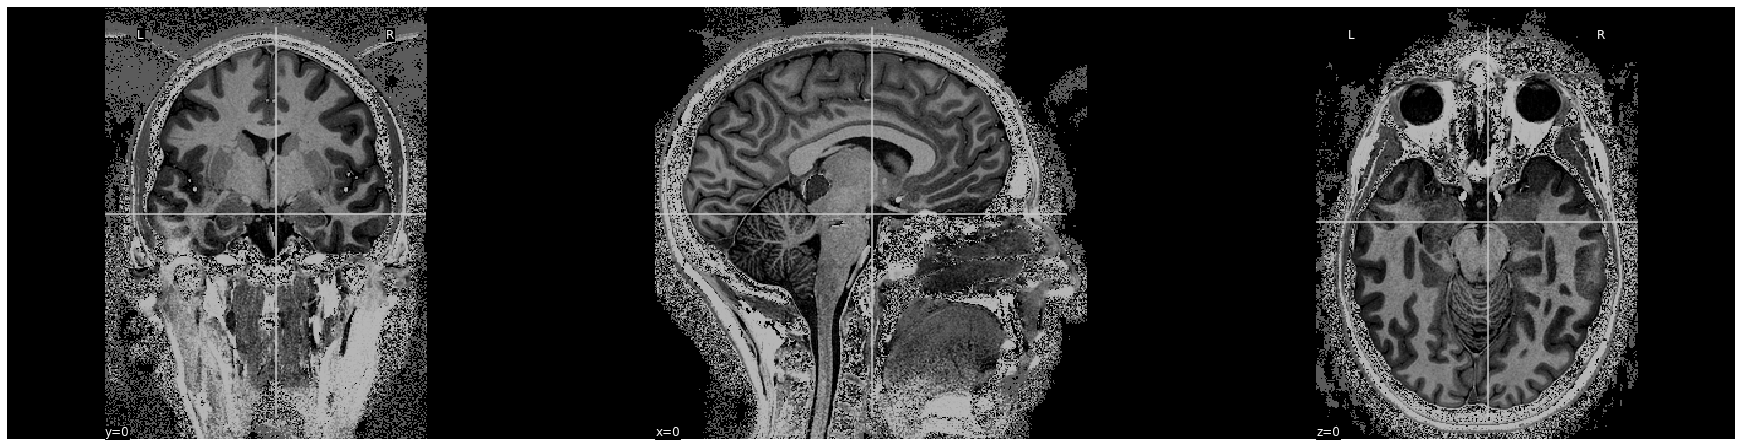

In [168]:
fig = plt.figure(figsize=(24, 6))
niplt.plot_anat(t1w, figure=fig, cut_coords=(0, 0, 0))

In [169]:
fname = in_dir + 'T1w.nii.gz'
nib.save(t1w,fname)
mp2ragedata['t1w'] = fname

## Skull stripping

In [170]:
skullstripping_results = nighres.brain.mp2rage_skullstripping(
                                            second_inversion=mp2ragedata['inv2'],
                                            t1_weighted=mp2ragedata['t1w'],
                                            save_data=True,
                                            file_name='full_brain',
                                            output_dir=out_dir, overwrite=False)



MP2RAGE Skull Stripping

Outputs will be saved to /data01/lorenzo/PROJECTS/layers/data/S01session1/brain_registration/
skip computation (use existing results)


In [171]:
skull_mask = '/data01/lorenzo/PROJECTS/layers/data/S01session1/brain_registration/full_brain_strip-mask.nii.gz'

/home/deangelis/anaconda3/envs/nighres/lib/python3.7/site-packages/nilearn/reporting/html_document.py:60: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  MAX_IMG_VIEWS_BEFORE_WARNING))



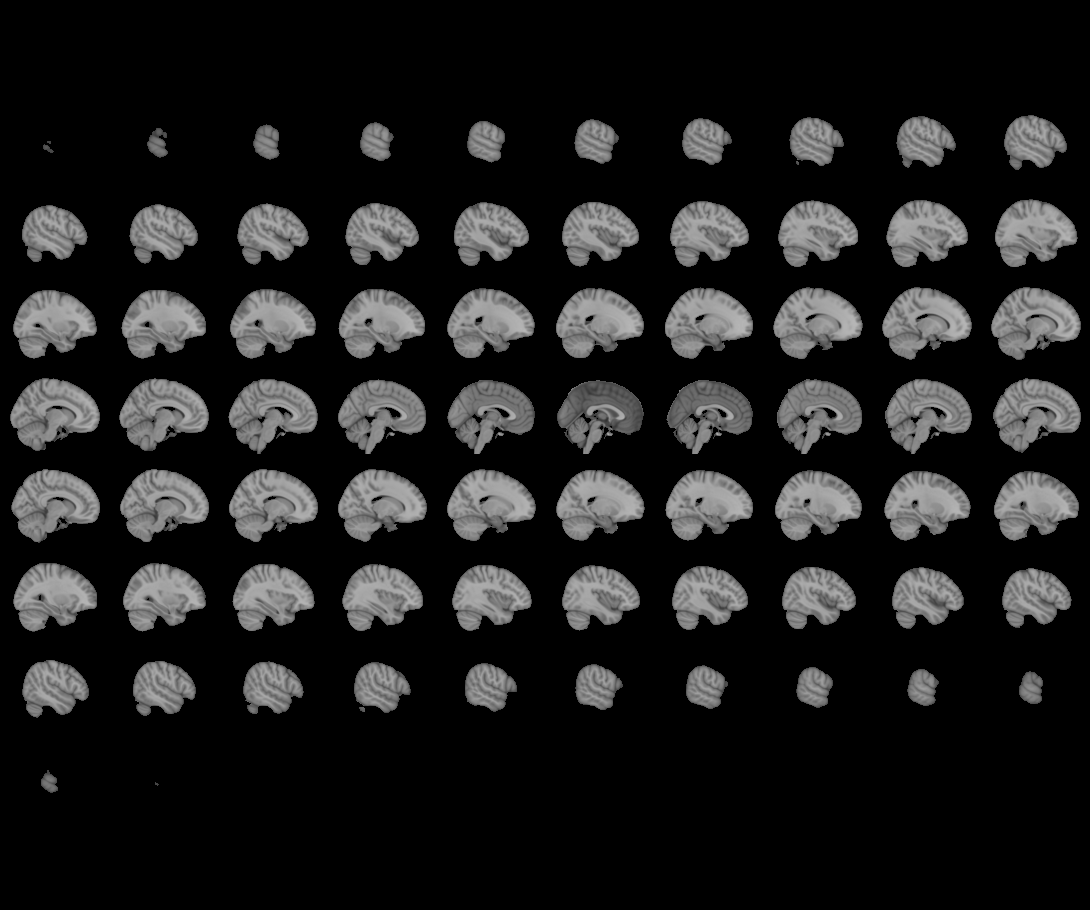
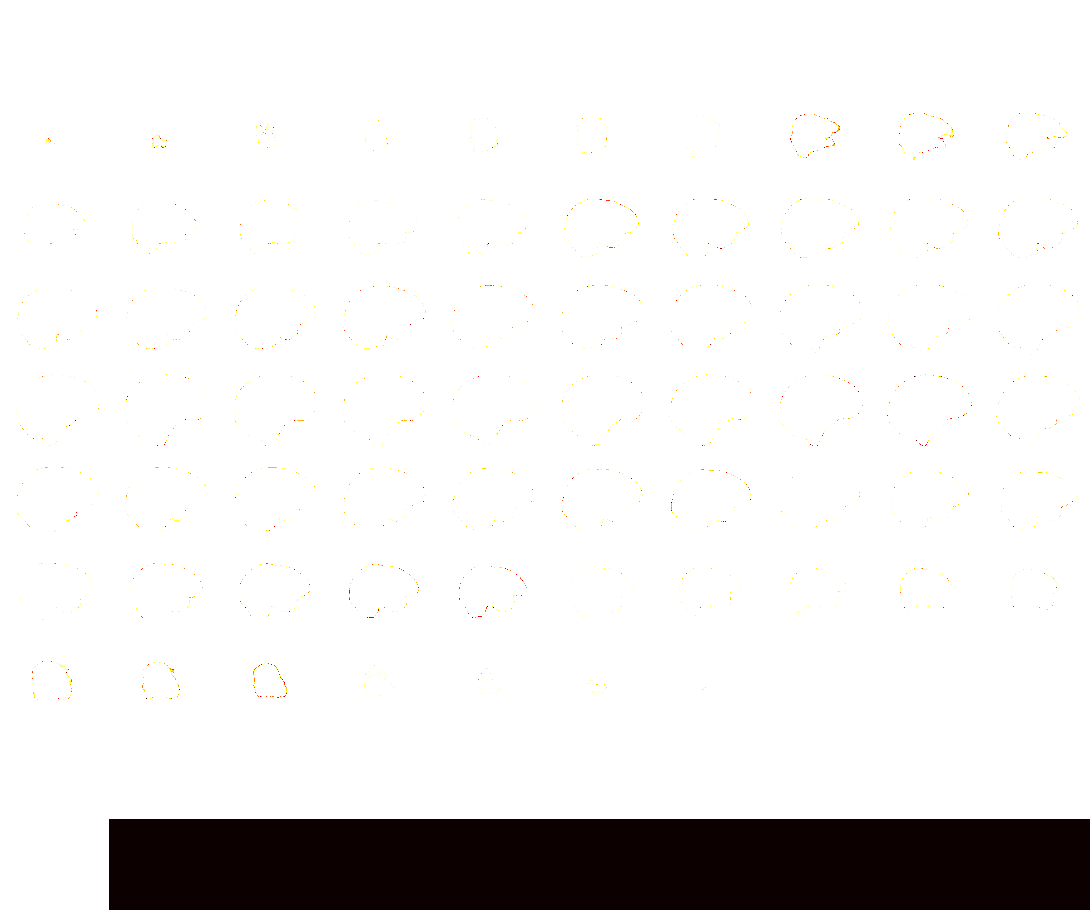

In [172]:
niplt.view_img(skull_mask)

In [173]:
t1w_masked = niimg.math_img('(im1>0.5)*im2',im1=skull_mask,im2=mp2ragedata['t1w'])
fname = in_dir + 'T1w_masked.nii.gz'
nib.save(t1w_masked,fname)
mp2ragedata['t1w_masked'] = fname

/home/deangelis/anaconda3/envs/nighres/lib/python3.7/site-packages/nilearn/image/resampling.py:584: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  fill_value=fill_value)
/home/deangelis/anaconda3/envs/nighres/lib/python3.7/site-packages/nilearn/plotting/find_cuts.py:122: RuntimeWarning: invalid value encountered in greater
  mask = np.abs(my_map) > (activation_threshold - eps)
/home/deangelis/anaconda3/envs/nighres/lib/python3.7/site-packages/nilearn/plotting/find_cuts.py:136: RuntimeWarning: invalid value encountered in greater
  second_mask = (np.abs(my_map) > second_threshold)
/home/deangelis/anaconda3/envs/nighres/lib/python3.7/site-packages/nilearn/reporting/html_document.py:60: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  MAX_IMG_VIEWS_BEFORE_WARNING))



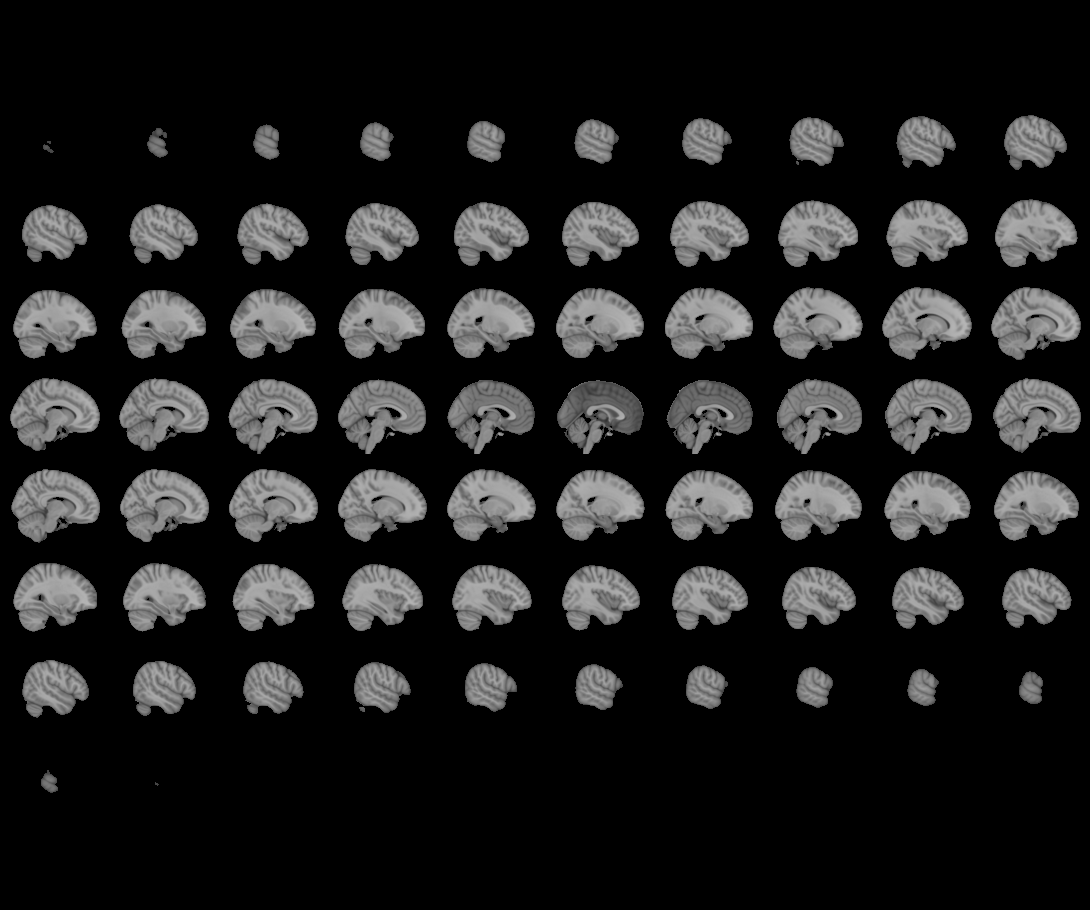
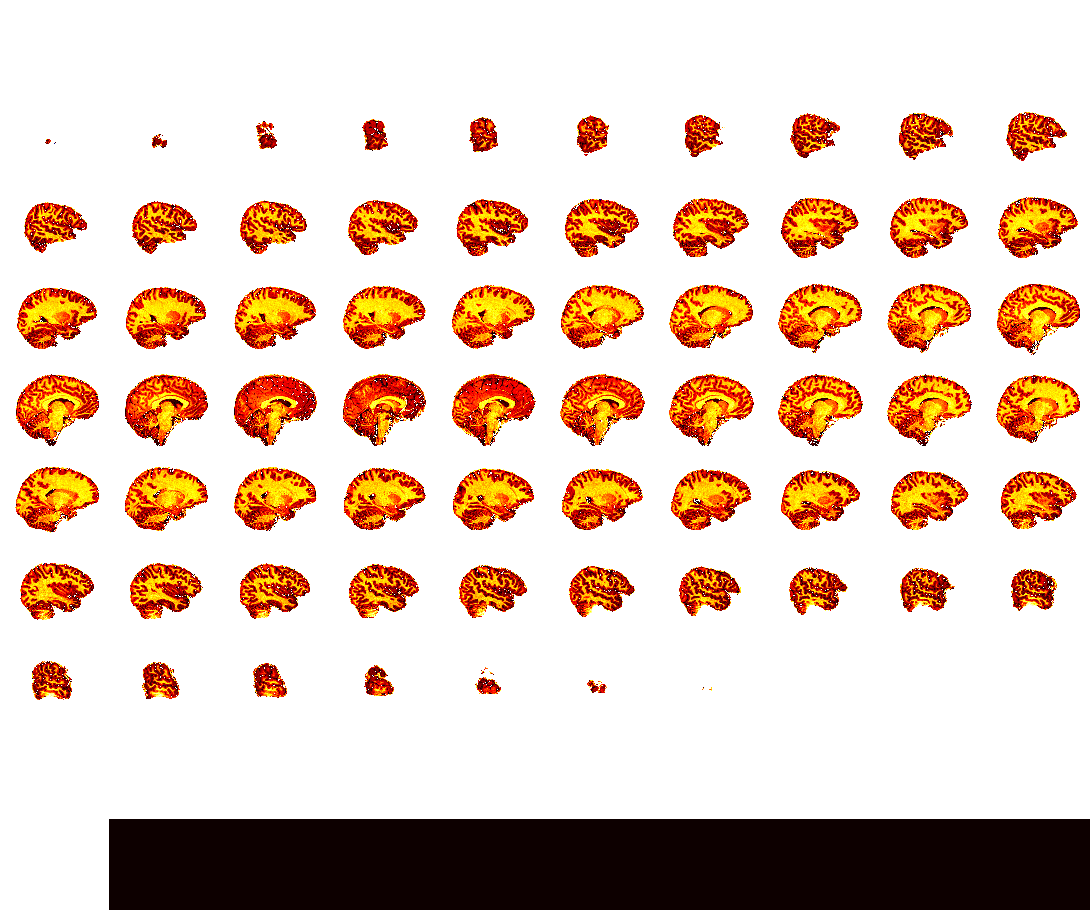

In [174]:
niplt.view_img(mp2ragedata['t1w_masked'])

## registration

Next, we use the masked data as input for co-registration. The T1 maps are used here as they are supposed to be more similar syn_results = nighres.registration.embedded_syn( source_image=skullstripping_results1['t1map_masked'], target_image=skullstripping_results2['t1map_masked'], coarse_iterations=0, medium_iterations=0, fine_iterations=0, run_rigid_first=True, cost_function='MutualInformation', interpolation='NearestNeighbor', save_data=True, file_name="sub001_sess1", output_dir=out_dir, overwrite=True)


In [177]:
icbm = fetch_icbm152_2009()

In [180]:
icbm['t1']

'/home/deangelis/nilearn_data/icbm152_2009/mni_icbm152_nlin_sym_09a/mni_icbm152_t1_tal_nlin_sym_09a.nii.gz'

In [181]:
t1_masked = math_img('im1*im2',im1 = icbm['t1'], im2 = icbm['mask'])
icbm['t1_masked'] = icbm['t1'].replace('.nii.gz','_masked.nii.gz')
nib.save(t1_masked,icbm['t1_masked'])
icbm['t1_masked']


'/home/deangelis/nilearn_data/icbm152_2009/mni_icbm152_nlin_sym_09a/mni_icbm152_t1_tal_nlin_sym_09a_masked.nii.gz'

In [185]:
syn_results = nighres.registration.embedded_antsreg(
                        source_image=skullstripping_results['t1w_masked'],
                        target_image=icbm['t1_masked'],
                        run_rigid=True, run_syn=True,
                        rigid_iterations=1000, coarse_iterations=40,
                        medium_iterations=0, fine_iterations=0,
                        cost_function='MutualInformation',
                        interpolation='NearestNeighbor',
                        save_data=True, file_name="syn_reg",
                        output_dir=out_dir, overwrite=True)


Embedded ANTs Registration Multi-contrasts

Outputs will be saved to /data01/lorenzo/PROJECTS/layers/data/S01session1/brain_registration/

Saving /data01/lorenzo/PROJECTS/layers/data/S01session1/brain_registration/syn_reg_tmp_srccoord.nii.gz

Saving /data01/lorenzo/PROJECTS/layers/data/S01session1/brain_registration/syn_reg_tmp_trgcoord.nii.gz
registering /data01/lorenzo/PROJECTS/layers/data/S01session1/brain_registration/full_brain_strip-t1w.nii.gz
 to /home/deangelis/nilearn_data/icbm152_2009/mni_icbm152_nlin_sym_09a/mni_icbm152_t1_tal_nlin_sym_09a_masked.nii.gz
antsRegistration --collapse-output-transforms 1 --dimensionality 3 --initialize-transforms-per-stage 0 --interpolation Linear --output syn_reg_tmp_syn --transform Rigid[0.1] --metric MI[/home/deangelis/nilearn_data/icbm152_2009/mni_icbm152_nlin_sym_09a/mni_icbm152_t1_tal_nlin_sym_09a_masked.nii.gz, /data01/lorenzo/PROJECTS/layers/data/S01session1/brain_registration/full_brain_strip-t1w.nii.gz, 1.000, 32, Random, 0.3 ] --conv

In [186]:
deformed = nighres.registration.apply_coordinate_mappings(
    image=mp2ragedata['t1w_masked'],
    mapping1=syn_results['mapping'],
    save_data=True,
    file_name="t1w_reg",
    output_dir=out_dir,
    overwrite=True
)


Apply coordinate mappings

Outputs will be saved to /data01/lorenzo/PROJECTS/layers/data/S01session1/brain_registration/

Saving /data01/lorenzo/PROJECTS/layers/data/S01session1/brain_registration/t1w_reg_def-img.nii.gz


In [187]:
mp2ragedata['t1w_reg'] = deformed['result']

/home/deangelis/anaconda3/envs/nighres/lib/python3.7/site-packages/nilearn/image/resampling.py:584: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  fill_value=fill_value)
/home/deangelis/anaconda3/envs/nighres/lib/python3.7/site-packages/nilearn/plotting/find_cuts.py:122: RuntimeWarning: invalid value encountered in greater
  mask = np.abs(my_map) > (activation_threshold - eps)
/home/deangelis/anaconda3/envs/nighres/lib/python3.7/site-packages/nilearn/plotting/find_cuts.py:136: RuntimeWarning: invalid value encountered in greater
  second_mask = (np.abs(my_map) > second_threshold)
/home/deangelis/anaconda3/envs/nighres/lib/python3.7/site-packages/nilearn/reporting/html_document.py:60: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  MAX_IMG_VIEWS_BEFORE_WARNING))



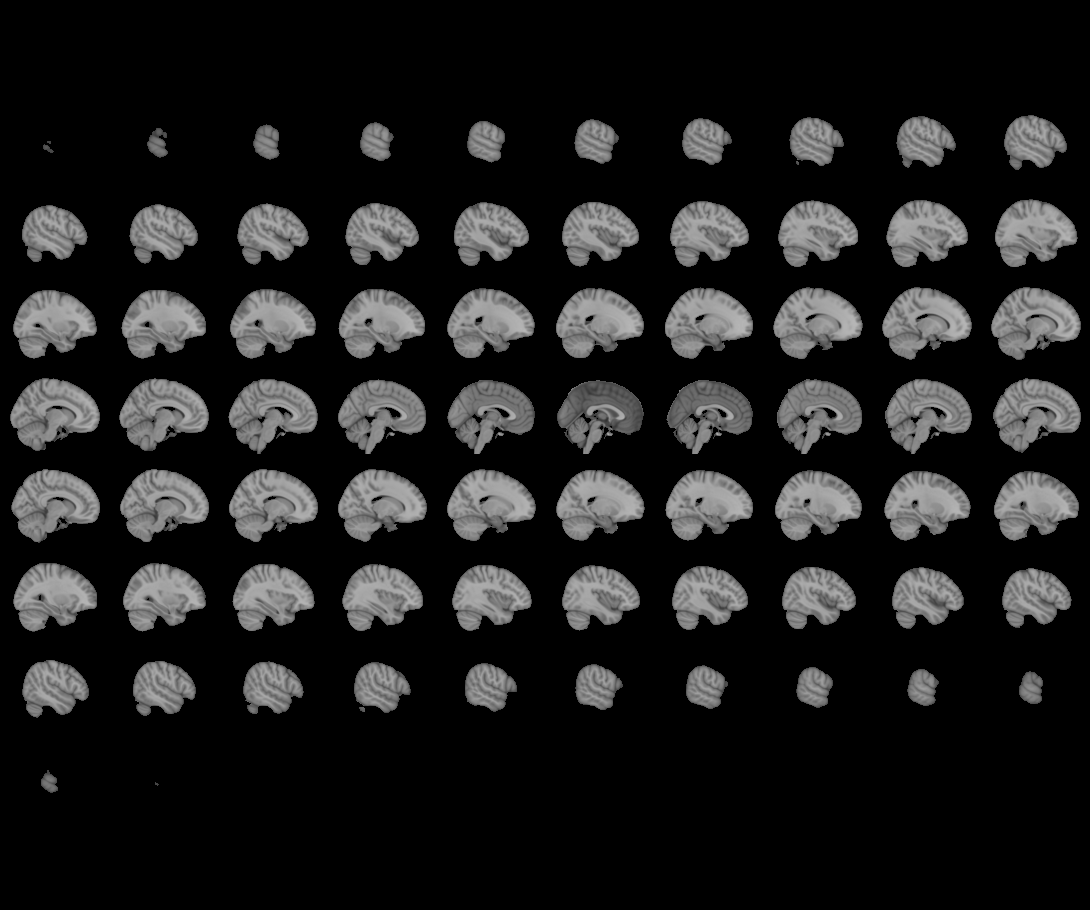
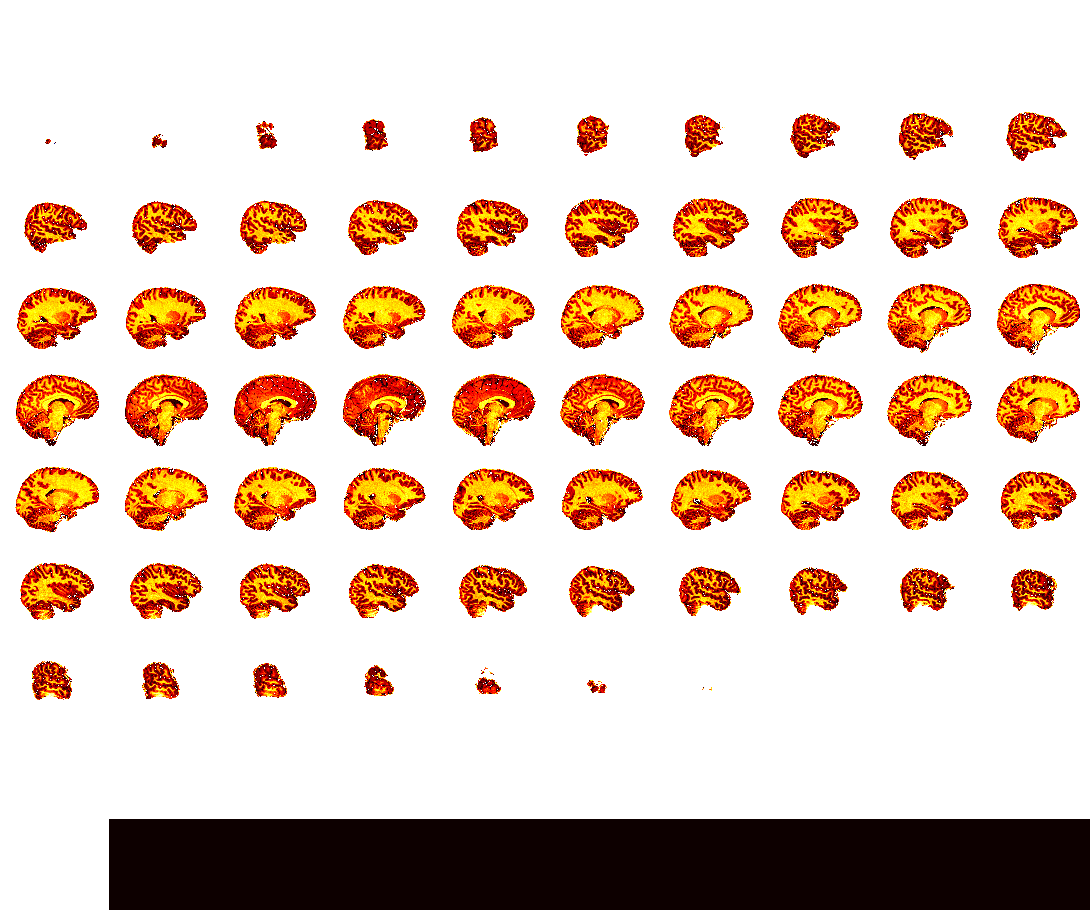

In [188]:
niplt.view_img(mp2ragedata['t1w_masked'])

/home/deangelis/anaconda3/envs/nighres/lib/python3.7/site-packages/nilearn/image/resampling.py:584: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  fill_value=fill_value)
/home/deangelis/anaconda3/envs/nighres/lib/python3.7/site-packages/nilearn/plotting/find_cuts.py:122: RuntimeWarning: invalid value encountered in greater
  mask = np.abs(my_map) > (activation_threshold - eps)
/home/deangelis/anaconda3/envs/nighres/lib/python3.7/site-packages/nilearn/plotting/find_cuts.py:136: RuntimeWarning: invalid value encountered in greater
  second_mask = (np.abs(my_map) > second_threshold)
/home/deangelis/anaconda3/envs/nighres/lib/python3.7/site-packages/nilearn/reporting/html_document.py:60: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  MAX_IMG_VIEWS_BEFORE_WARNING))



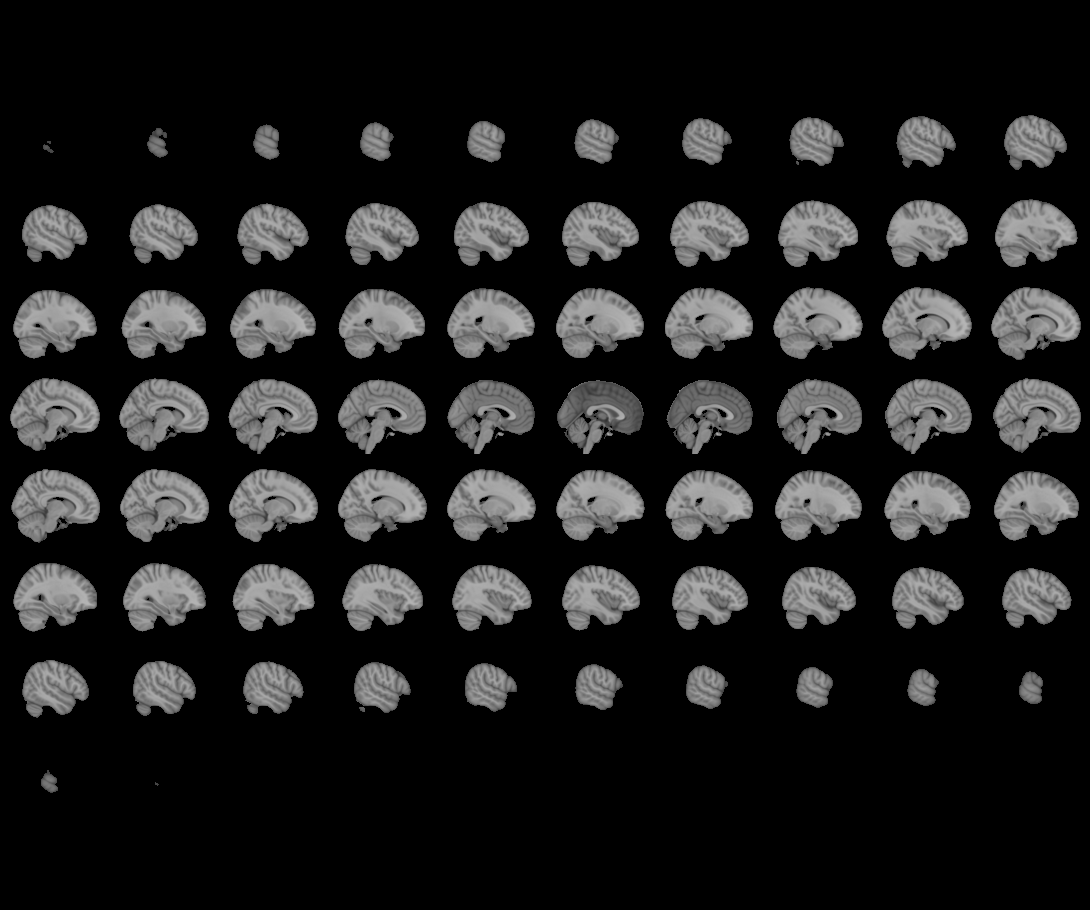
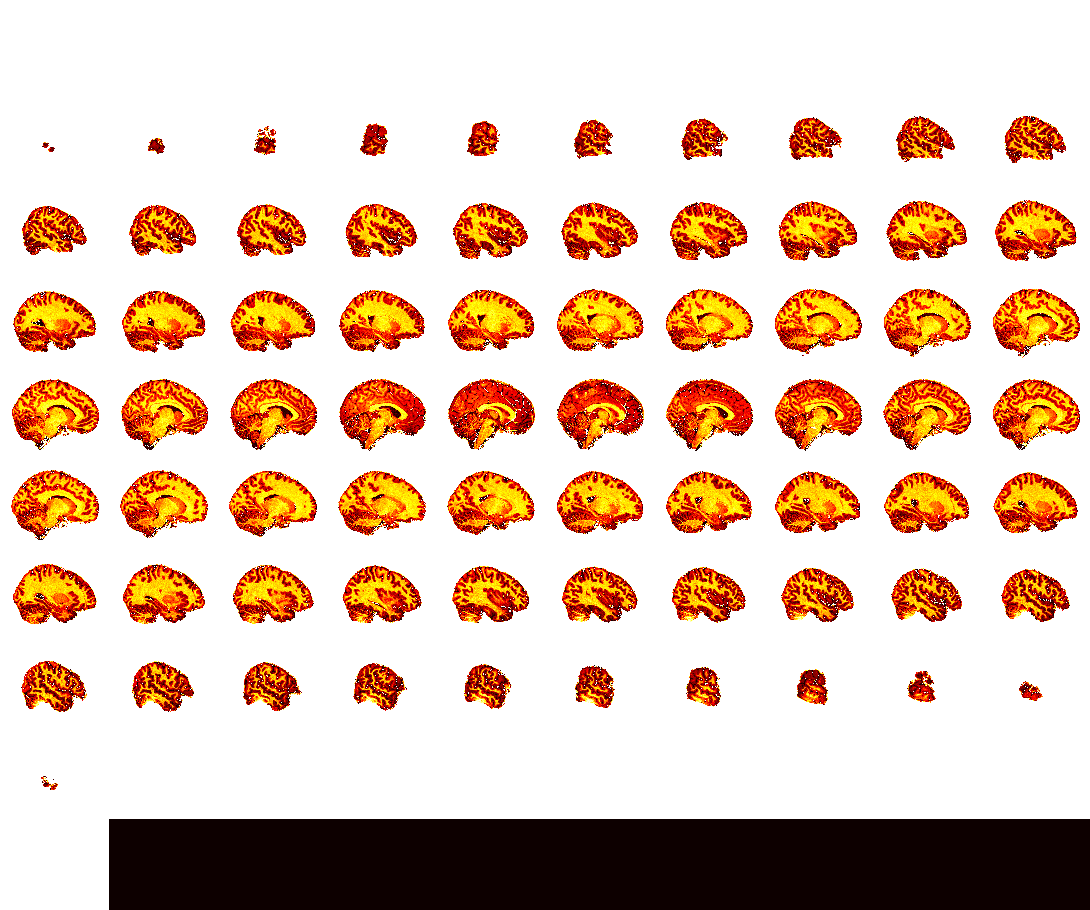

In [127]:
niplt.view_img(mp2ragedata['t1w_reg'])

## Now the partial images

In [189]:
t123depi_data = {
                           'inv1' : in_dir + 'S{:02d}_session{}_T123DEPI_08_INV1_15_1/S{:02d}_session{}_T123DEPI_08_INV1_15_1-t000-d0008-0000.nii.gz'.format(sub,ses,sub,ses),
                           'inv1ph' : in_dir + 'S{:02d}_session{}_T123DEPI_08_INV1_15_1/S{:02d}_session{}_T123DEPI_08_INV1_15_1-t003-d0008-0000.nii.gz'.format(sub,ses,sub,ses),
                           'inv2' : in_dir + 'S{:02d}_session{}_T123DEPI_08_INV2_16_1/S{:02d}_session{}_T123DEPI_08_INV2_16_1-t000-d0008-0000.nii.gz'.format(sub,ses,sub,ses),
                           'inv2ph' : in_dir + 'S{:02d}_session{}_T123DEPI_08_INV2_16_1/S{:02d}_session{}_T123DEPI_08_INV2_16_1-t003-d0008-0000.nii.gz'.format(sub,ses,sub,ses)
                          
}
for f in t123depi_data:
    print(os.path.isfile(t123depi_data[f]))

True
True
True
True


In [190]:
fitter_3DEPI = pymp2rage.MP2RAGE(MPRAGE_tr=6.2,
                           invtimesAB=[0.67, 3.855],
                           flipangleABdegree=[7, 5],
                           nZslices=150,
                           FLASH_tr=[0.0062, 0.0320],
                           inv1= t123depi_data['inv1'],
                           inv1ph= t123depi_data['inv1ph'],
                           inv2= t123depi_data['inv2'],
                           inv2ph= t123depi_data['inv2ph']
                          )


In [191]:
t1w_3DEPI = fitter_3DEPI.t1w_uni


/home/deangelis/anaconda3/envs/nighres/lib/python3.7/site-packages/pymp2rage/mp2rage.py:163: RuntimeWarning: invalid value encountered in true_divide
  self._t1w_uni = (np.real(compINV1*compINV2/(compINV1**2 + compINV2**2)))*4095+2048


In [193]:
fname = in_dir + 'T1w_3DEPI.nii.gz'
nib.save(t1w_3DEPI,fname)
t123depi_data['t1w'] = fname

In [197]:
skull_mask_3DEPI = niimg.resample_to_img(skull_mask,nib.load(t123depi_data['t1w']))
skull_mask_3DEPI = niimg.index_img(skull_mask_3DEPI,0)

/home/deangelis/anaconda3/envs/nighres/lib/python3.7/site-packages/nilearn/reporting/html_document.py:60: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  MAX_IMG_VIEWS_BEFORE_WARNING))



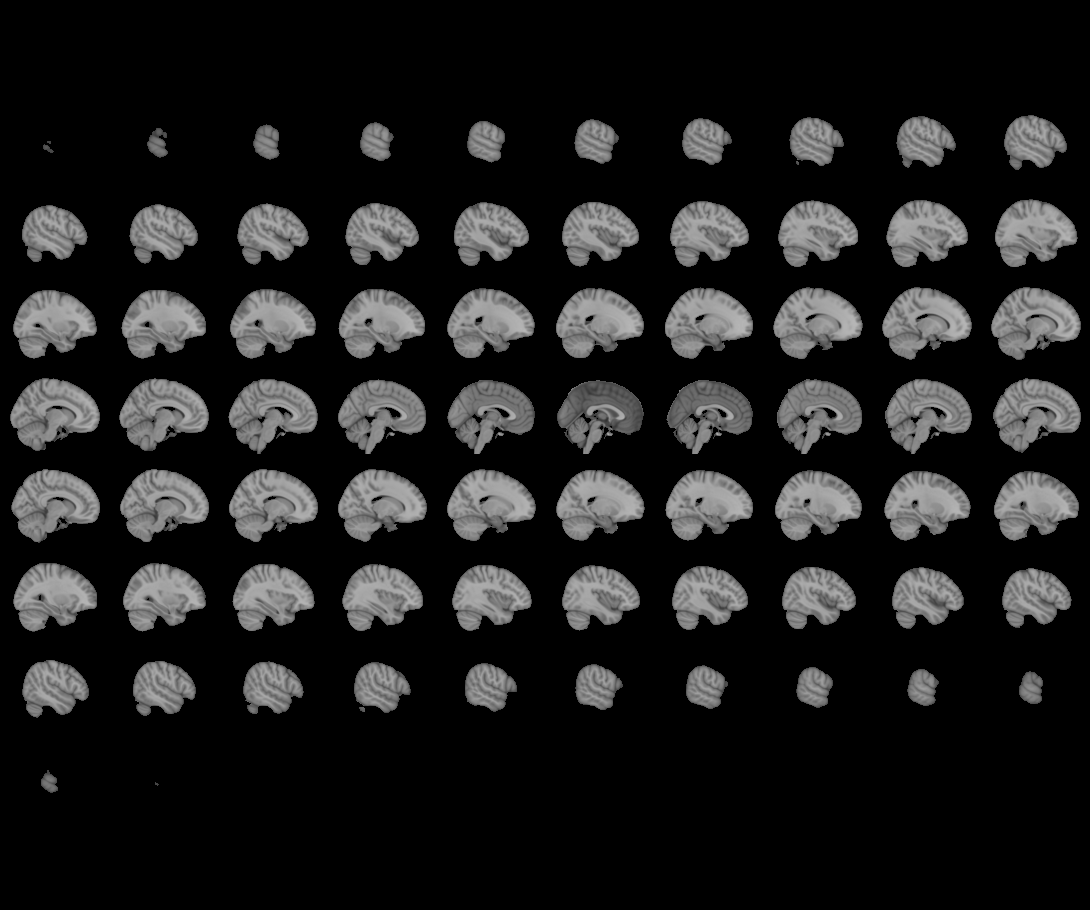
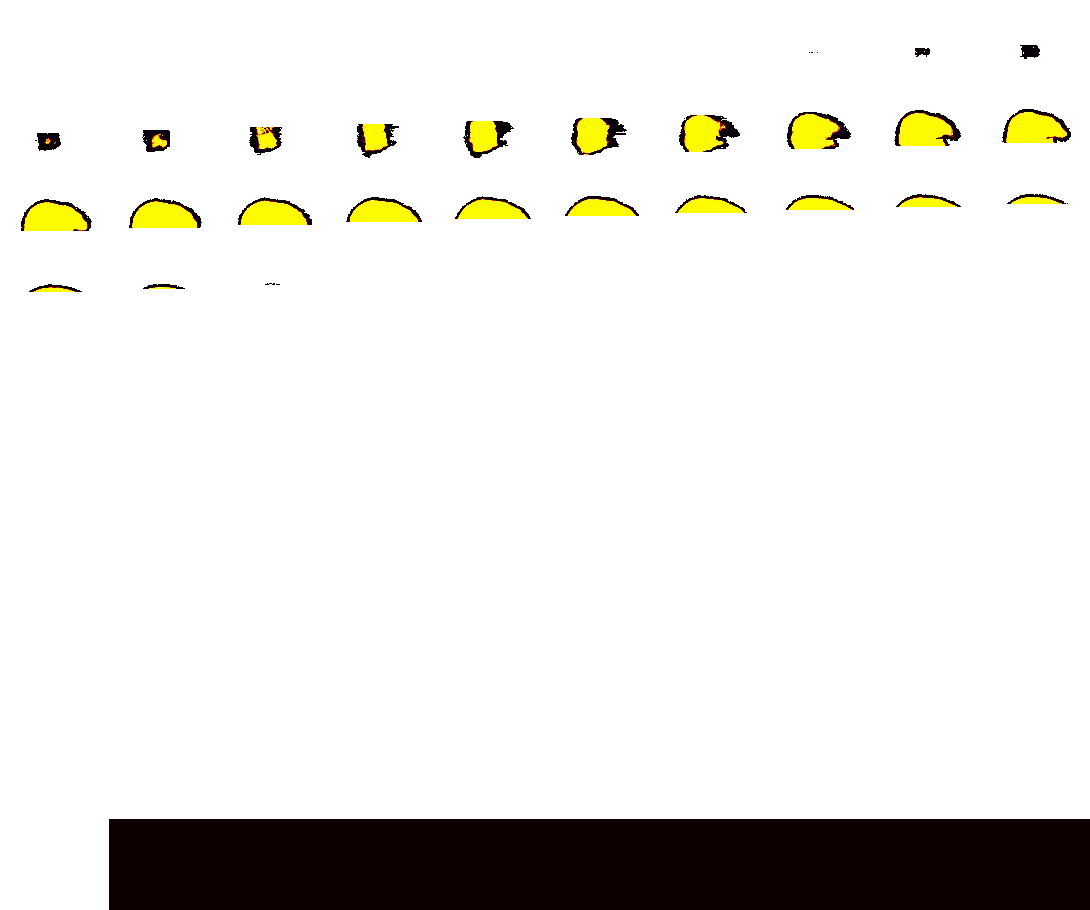

In [198]:
niplt.view_img(skull_mask_3DEPI)

In [199]:
t1W_3DEPI_masked = math_img('(im1 > 0.5)*im2', im1=skull_mask_3DEPI,im2 = t123depi_data['t1w'])
fname = in_dir + 'T1w_3DEPI_masked.nii.gz'
nib.save(t1W_3DEPI_masked,fname)
t123depi_data['t1w_masked'] = fname

/home/deangelis/anaconda3/envs/nighres/lib/python3.7/site-packages/nilearn/image/resampling.py:584: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  fill_value=fill_value)
/home/deangelis/anaconda3/envs/nighres/lib/python3.7/site-packages/nilearn/plotting/find_cuts.py:122: RuntimeWarning: invalid value encountered in greater
  mask = np.abs(my_map) > (activation_threshold - eps)
/home/deangelis/anaconda3/envs/nighres/lib/python3.7/site-packages/nilearn/plotting/find_cuts.py:136: RuntimeWarning: invalid value encountered in greater
  second_mask = (np.abs(my_map) > second_threshold)
/home/deangelis/anaconda3/envs/nighres/lib/python3.7/site-packages/nilearn/reporting/html_document.py:60: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  MAX_IMG_VIEWS_BEFORE_WARNING))



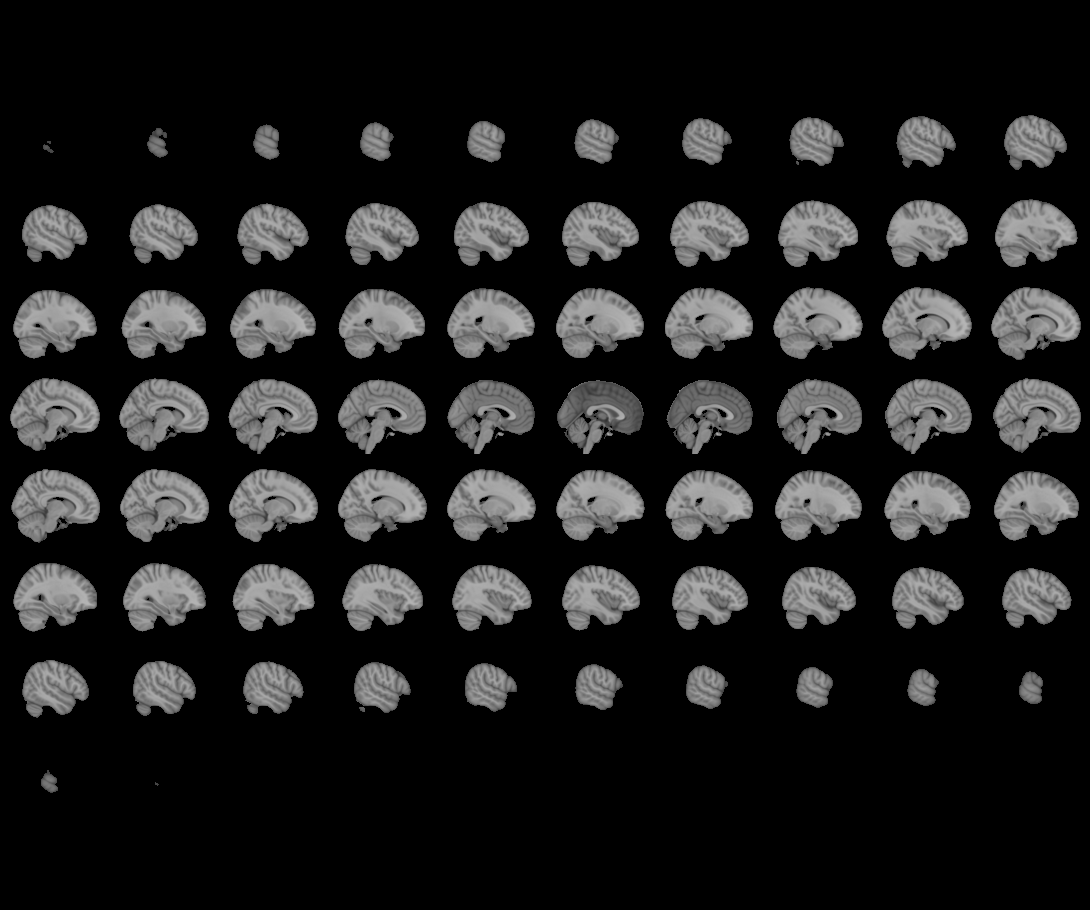
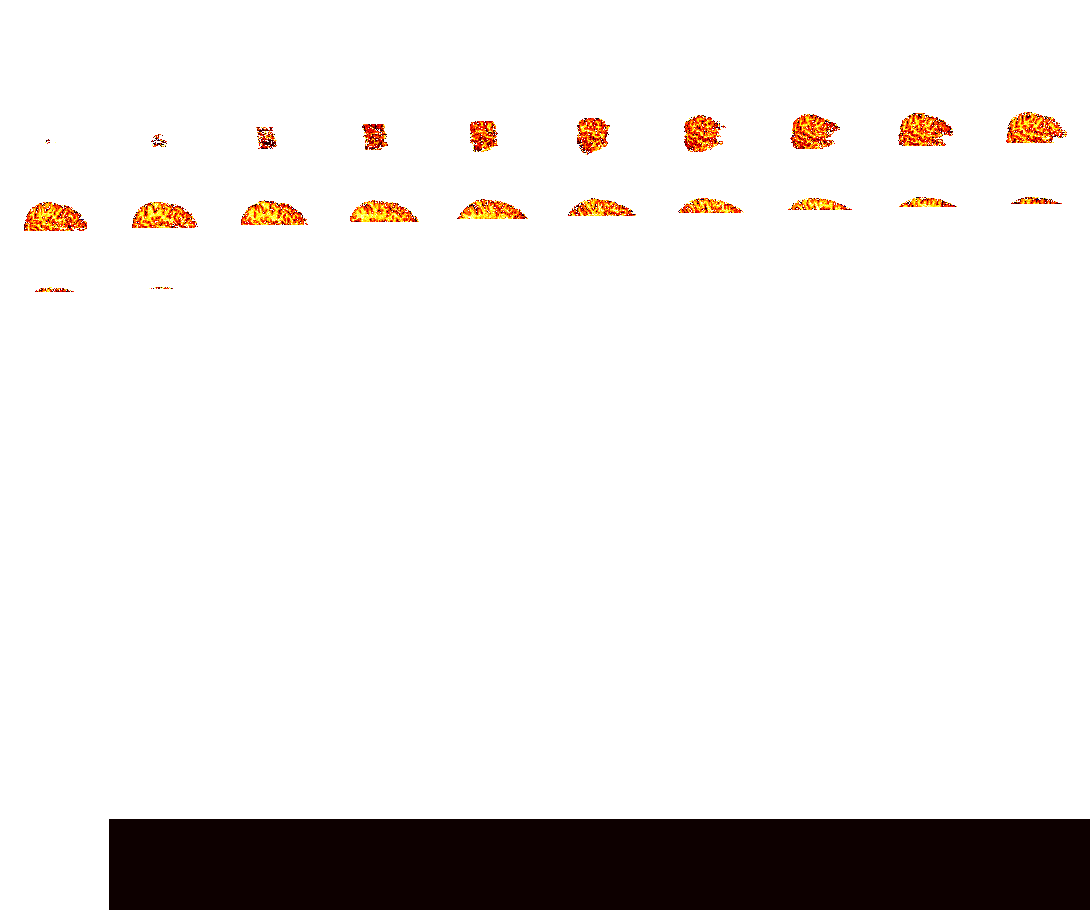

In [202]:
niplt.view_img(t123depi_data['t1w_masked'])

In [215]:
mp2ragedata

{'inv1': '/data01/lorenzo/PROJECTS/layers/data/S01session1/S01_session1_MP2RAGE_INV1_064mmL_11_1/S01_session1_MP2RAGE_INV1_064mmL_11_1-t000.nii',
 'inv1ph': '/data01/lorenzo/PROJECTS/layers/data/S01session1/S01_session1_MP2RAGE_INV1_064mmL_11_1/S01_session1_MP2RAGE_INV1_064mmL_11_1-t003.nii',
 'inv2': '/data01/lorenzo/PROJECTS/layers/data/S01session1/S01_session1_MP2RAGE_INV2_064mmL_10_1/S01_session1_MP2RAGE_INV2_064mmL_10_1-t000.nii',
 'inv2ph': '/data01/lorenzo/PROJECTS/layers/data/S01session1/S01_session1_MP2RAGE_INV2_064mmL_10_1/S01_session1_MP2RAGE_INV2_064mmL_10_1-t003.nii',
 't1w': '/data01/lorenzo/PROJECTS/layers/data/S01session1/T1w.nii.gz',
 't1w_masked': '/data01/lorenzo/PROJECTS/layers/data/S01session1/T1w_masked.nii.gz',
 't1w_reg': '/data01/lorenzo/PROJECTS/layers/data/S01session1/brain_registration/t1w_reg_def-img.nii.gz'}

In [203]:
## Apply registration between 3DEPI and MP2RAGE

In [217]:
MP2RAGE_3DEPI = niimg.resample_to_img(mp2ragedata['t1w_reg'],nib.load(t123depi_data['t1w_masked']))


/home/deangelis/anaconda3/envs/nighres/lib/python3.7/site-packages/nilearn/image/resampling.py:584: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  fill_value=fill_value)


/home/deangelis/anaconda3/envs/nighres/lib/python3.7/site-packages/nilearn/image/resampling.py:584: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  fill_value=fill_value)
/home/deangelis/anaconda3/envs/nighres/lib/python3.7/site-packages/nilearn/plotting/find_cuts.py:122: RuntimeWarning: invalid value encountered in greater
  mask = np.abs(my_map) > (activation_threshold - eps)
/home/deangelis/anaconda3/envs/nighres/lib/python3.7/site-packages/nilearn/plotting/find_cuts.py:136: RuntimeWarning: invalid value encountered in greater
  second_mask = (np.abs(my_map) > second_threshold)
/home/deangelis/anaconda3/envs/nighres/lib/python3.7/site-packages/nilearn/reporting/html_document.py:60: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  MAX_IMG_VIEWS_BEFORE_WARNING))



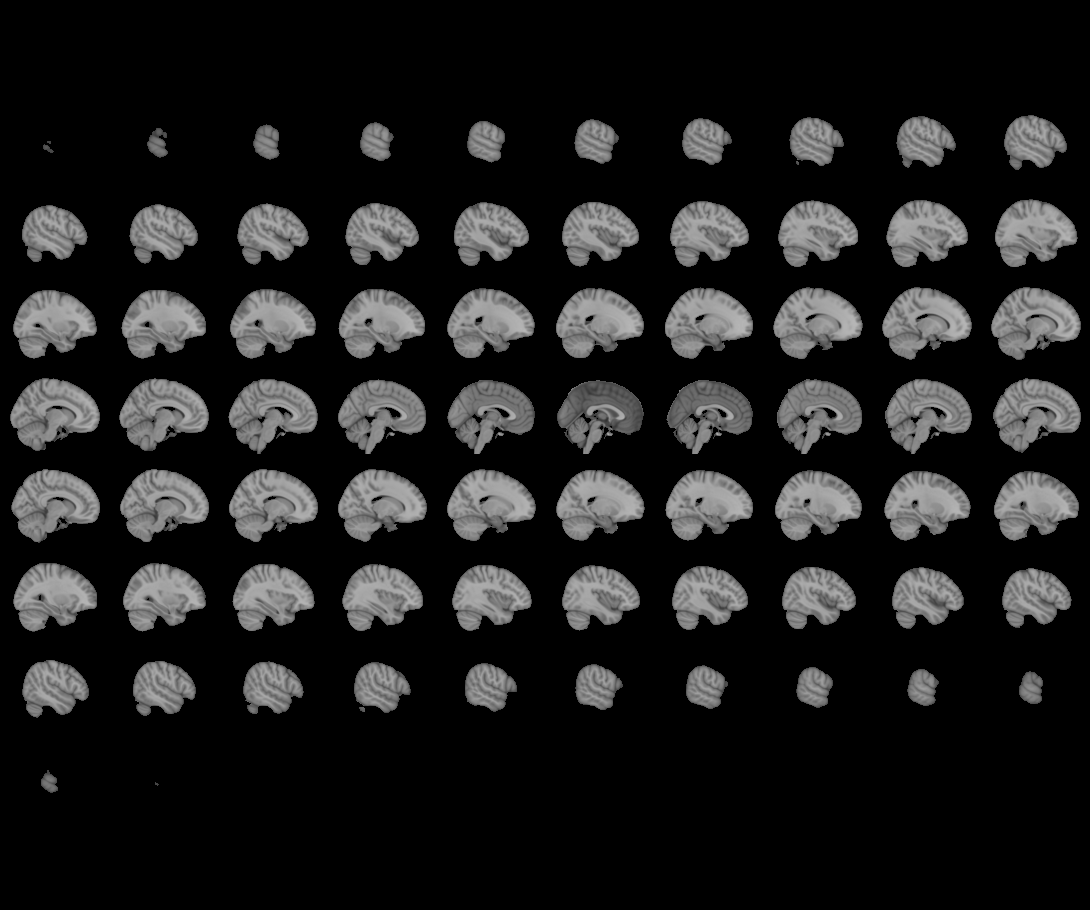
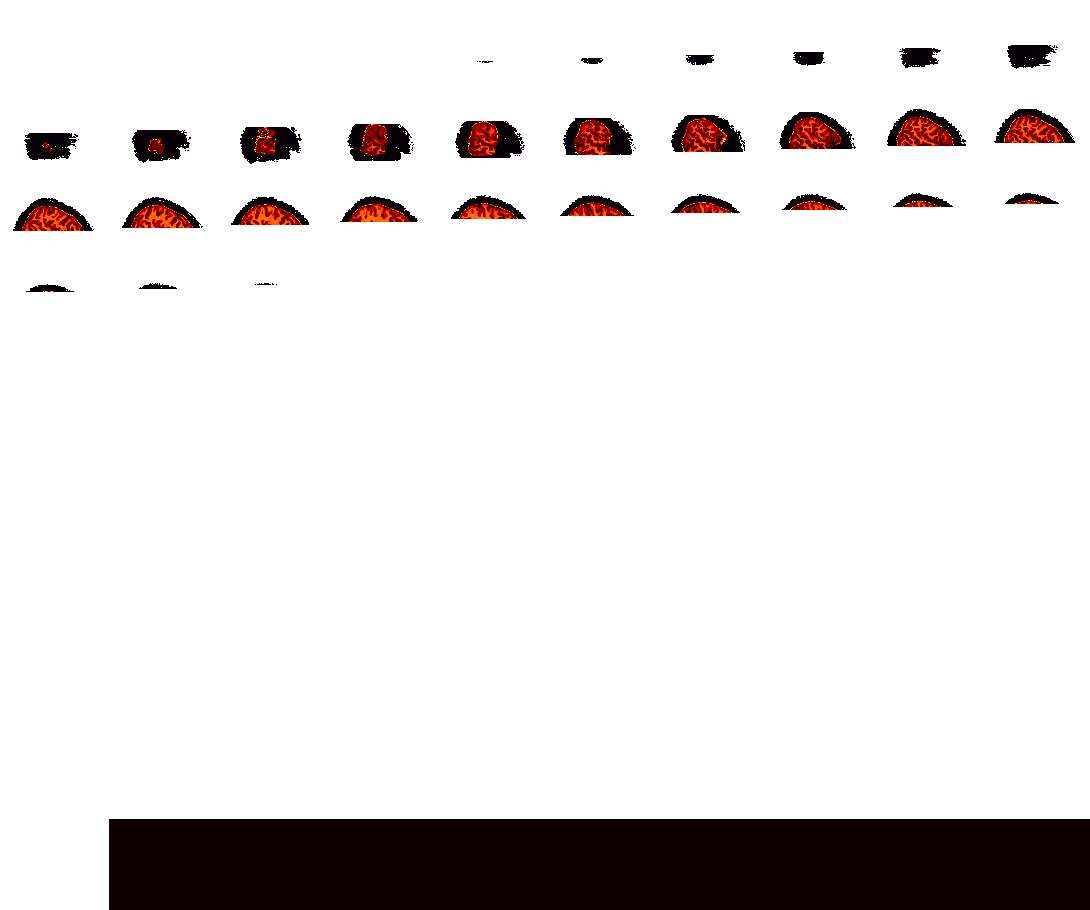

In [218]:
fname = out_dir + 't1w_reg_def-img_partial.nii.gz'
nib.save(MP2RAGE_3DEPI, fname)
mp2ragedata['t1w_reg_partial'] = fname

niplt.view_img(mp2ragedata['t1w_reg_partial'])

In [220]:
t123DEPI2MP2RAGE = nighres.registration.embedded_antsreg(
                        source_image=t123depi_data['t1w_masked'],
                        target_image=mp2ragedata['t1w_reg_partial'],
                        run_rigid=True, run_syn=True,
                        rigid_iterations=1000, coarse_iterations=40,
                        medium_iterations=0, fine_iterations=0,
                        cost_function='MutualInformation',
                        interpolation='NearestNeighbor',
                        save_data=True, file_name="syn_reg",
                        output_dir=out_dir, overwrite=True)


Embedded ANTs Registration Multi-contrasts

Outputs will be saved to /data01/lorenzo/PROJECTS/layers/data/S01session1/brain_registration/

Saving /data01/lorenzo/PROJECTS/layers/data/S01session1/brain_registration/syn_reg_tmp_srccoord.nii.gz

Saving /data01/lorenzo/PROJECTS/layers/data/S01session1/brain_registration/syn_reg_tmp_trgcoord.nii.gz
registering /data01/lorenzo/PROJECTS/layers/data/S01session1/T1w_3DEPI_masked.nii.gz
 to /data01/lorenzo/PROJECTS/layers/data/S01session1/brain_registrationt1w_reg_def-img_partial.nii.gz
antsRegistration --collapse-output-transforms 1 --dimensionality 3 --initialize-transforms-per-stage 0 --interpolation Linear --output syn_reg_tmp_syn --transform Rigid[0.1] --metric MI[/data01/lorenzo/PROJECTS/layers/data/S01session1/brain_registrationt1w_reg_def-img_partial.nii.gz, /data01/lorenzo/PROJECTS/layers/data/S01session1/T1w_3DEPI_masked.nii.gz, 1.000, 32, Random, 0.3 ] --convergence [1000x1000x1000, 1e-06, 10 ] --smoothing-sigmas 3.0x2.0x1.0 --shrink

In [223]:
deformed = nighres.registration.apply_coordinate_mappings(
    image=t123depi_data['t1w_masked'],
    mapping1=t123DEPI2MP2RAGE['mapping'],
    save_data=True,
    file_name="t1w_3DEPI_reg",
    output_dir=out_dir,
    overwrite=True
)


Apply coordinate mappings

Outputs will be saved to /data01/lorenzo/PROJECTS/layers/data/S01session1/brain_registration/

Saving /data01/lorenzo/PROJECTS/layers/data/S01session1/brain_registration/t1w_3DEPI_reg_def-img.nii.gz


In [224]:
t123depi_data['t1w_reg'] = deformed['result']

/home/deangelis/anaconda3/envs/nighres/lib/python3.7/site-packages/nilearn/image/resampling.py:584: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  fill_value=fill_value)
/home/deangelis/anaconda3/envs/nighres/lib/python3.7/site-packages/nilearn/plotting/find_cuts.py:122: RuntimeWarning: invalid value encountered in greater
  mask = np.abs(my_map) > (activation_threshold - eps)
/home/deangelis/anaconda3/envs/nighres/lib/python3.7/site-packages/nilearn/plotting/find_cuts.py:136: RuntimeWarning: invalid value encountered in greater
  second_mask = (np.abs(my_map) > second_threshold)
/home/deangelis/anaconda3/envs/nighres/lib/python3.7/site-packages/nilearn/reporting/html_document.py:60: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  MAX_IMG_VIEWS_BEFORE_WARNING))



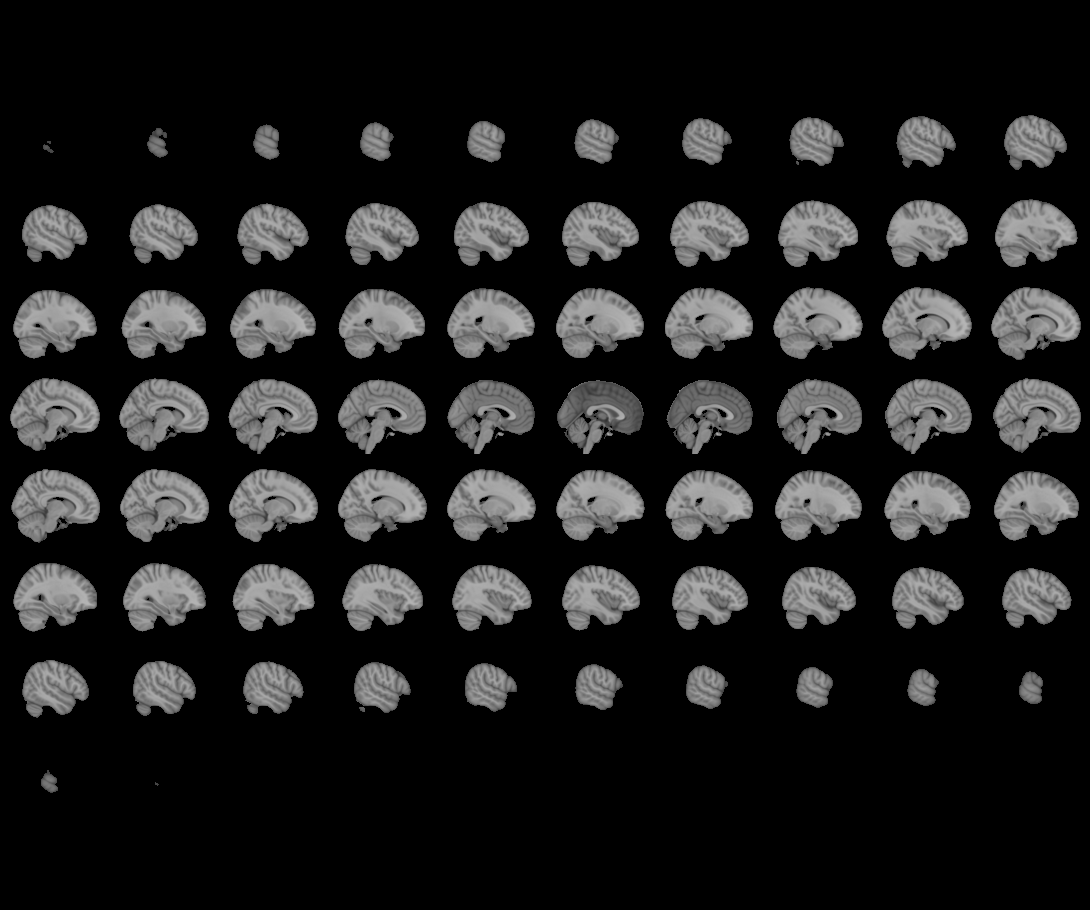
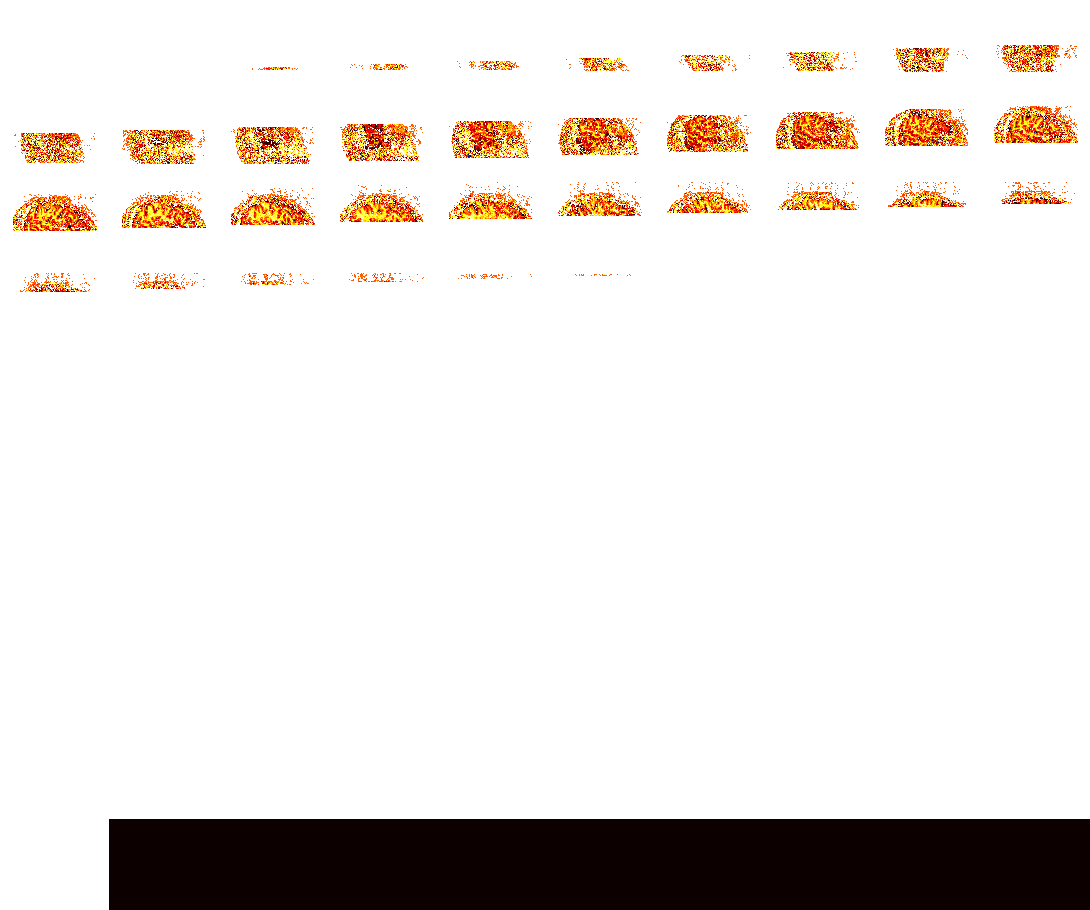

In [227]:
niplt.view_img(t123depi_data['t1w'])

/home/deangelis/anaconda3/envs/nighres/lib/python3.7/site-packages/nilearn/image/resampling.py:584: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  fill_value=fill_value)
/home/deangelis/anaconda3/envs/nighres/lib/python3.7/site-packages/nilearn/plotting/find_cuts.py:122: RuntimeWarning: invalid value encountered in greater
  mask = np.abs(my_map) > (activation_threshold - eps)
/home/deangelis/anaconda3/envs/nighres/lib/python3.7/site-packages/nilearn/plotting/find_cuts.py:136: RuntimeWarning: invalid value encountered in greater
  second_mask = (np.abs(my_map) > second_threshold)
/home/deangelis/anaconda3/envs/nighres/lib/python3.7/site-packages/nilearn/reporting/html_document.py:60: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  MAX_IMG_VIEWS_BEFORE_WARNING))



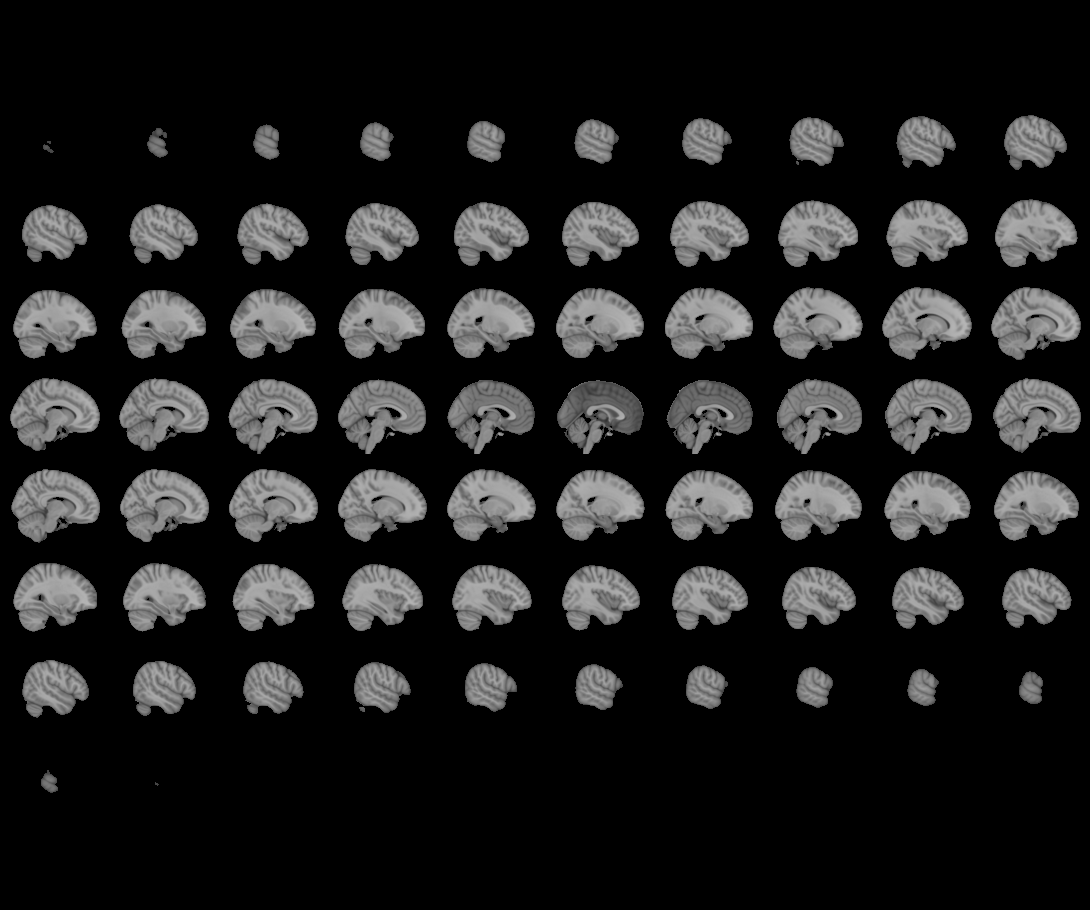
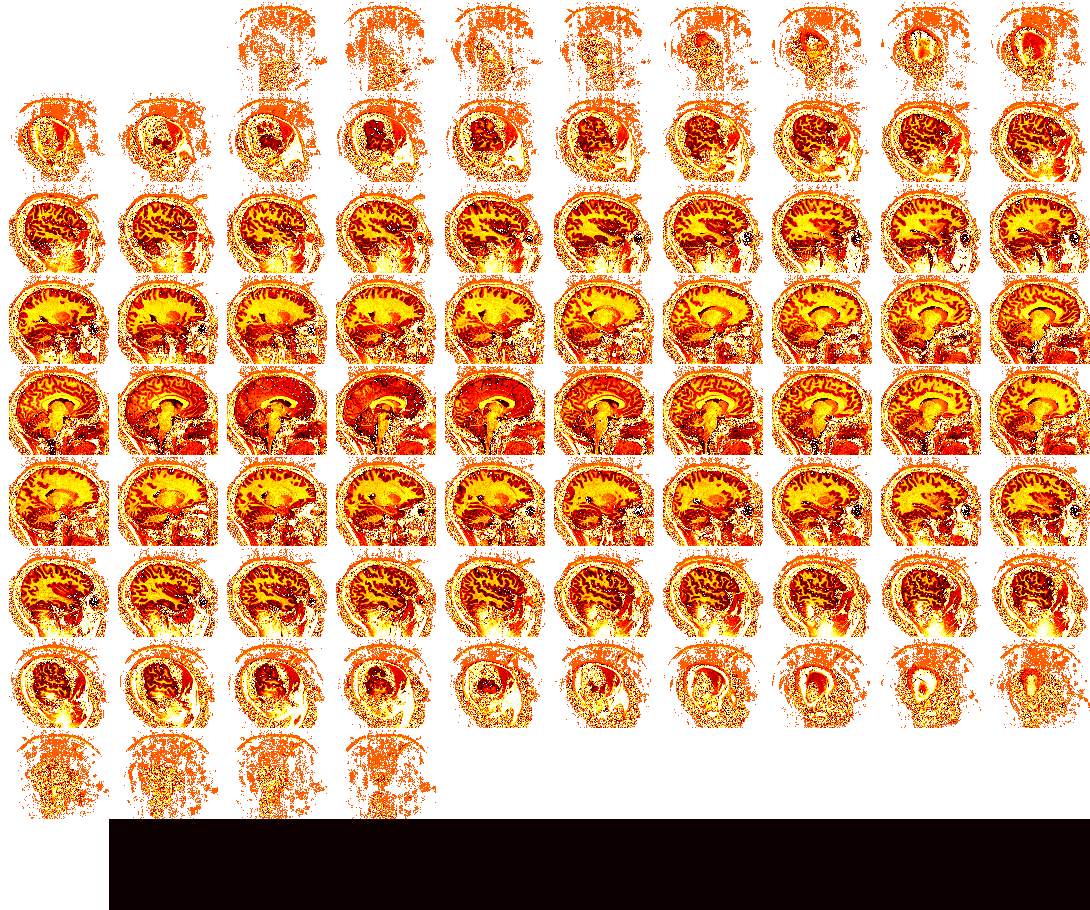

In [232]:
niplt.view_img(mp2ragedata['t1w'])

In [230]:
skullstripping_results = nighres.brain.mp2rage_skullstripping(
                                            second_inversion=mp2ragedata['inv2'],
                                            t1_weighted=mp2ragedata['t1w'],
#                                             save_data=True,
#                                             file_name='full_brain',
#                                             output_dir=out_dir, overwrite=False
    skip_zero_values=Tru
)


Intensity-based Skull Stripping

 The underlying Java code did not execute cleanly: 
<class 'nighresjava.JavaError'>


JavaError: <super: <class 'JavaError'>, <JavaError object>>
    Java stacktrace:
java.lang.ArrayIndexOutOfBoundsException


In [145]:
resampled = niimg.resample_to_img(t123depi_data['t1w_masked'],mp2ragedata['t1w_masked'])

deformed = nighres.registration.apply_coordinate_mappings(
    image=resampled,
    mapping1=syn_results['mapping'],
    save_data=True,
    file_name="t1w_3DEPI_projreg",
    output_dir=out_dir,
    overwrite=True
)

resampled_inv = niimg.resample_to_img(deformed['result'],t123depi_data['t1w_masked'])



/home/deangelis/anaconda3/envs/nighres/lib/python3.7/site-packages/nilearn/image/resampling.py:584: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  fill_value=fill_value)



Apply coordinate mappings

Outputs will be saved to /data01/lorenzo/PROJECTS/layers/data/S01session1/brain_registration/

Saving /data01/lorenzo/PROJECTS/layers/data/S01session1/brain_registration/t1w_3DEPI_projreg_def-img.nii.gz


/home/deangelis/anaconda3/envs/nighres/lib/python3.7/site-packages/nilearn/image/resampling.py:584: RuntimeWarning: NaNs or infinite values are present in the data passed to resample. This is a bad thing as they make resampling ill-defined and much slower.
  fill_value=fill_value)


In [146]:
t123depi_data['t1w_reg'] = deformed['result']

/home/deangelis/anaconda3/envs/nighres/lib/python3.7/site-packages/nilearn/reporting/html_document.py:60: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  MAX_IMG_VIEWS_BEFORE_WARNING))



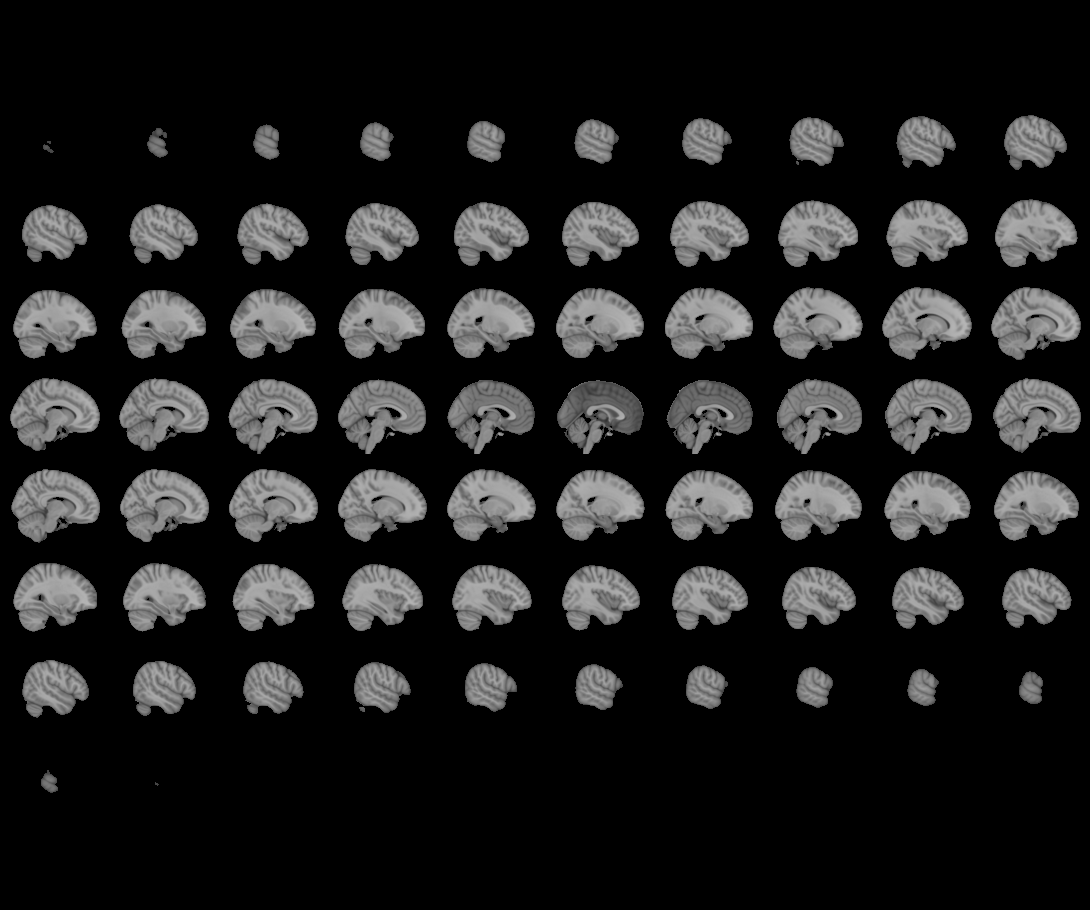
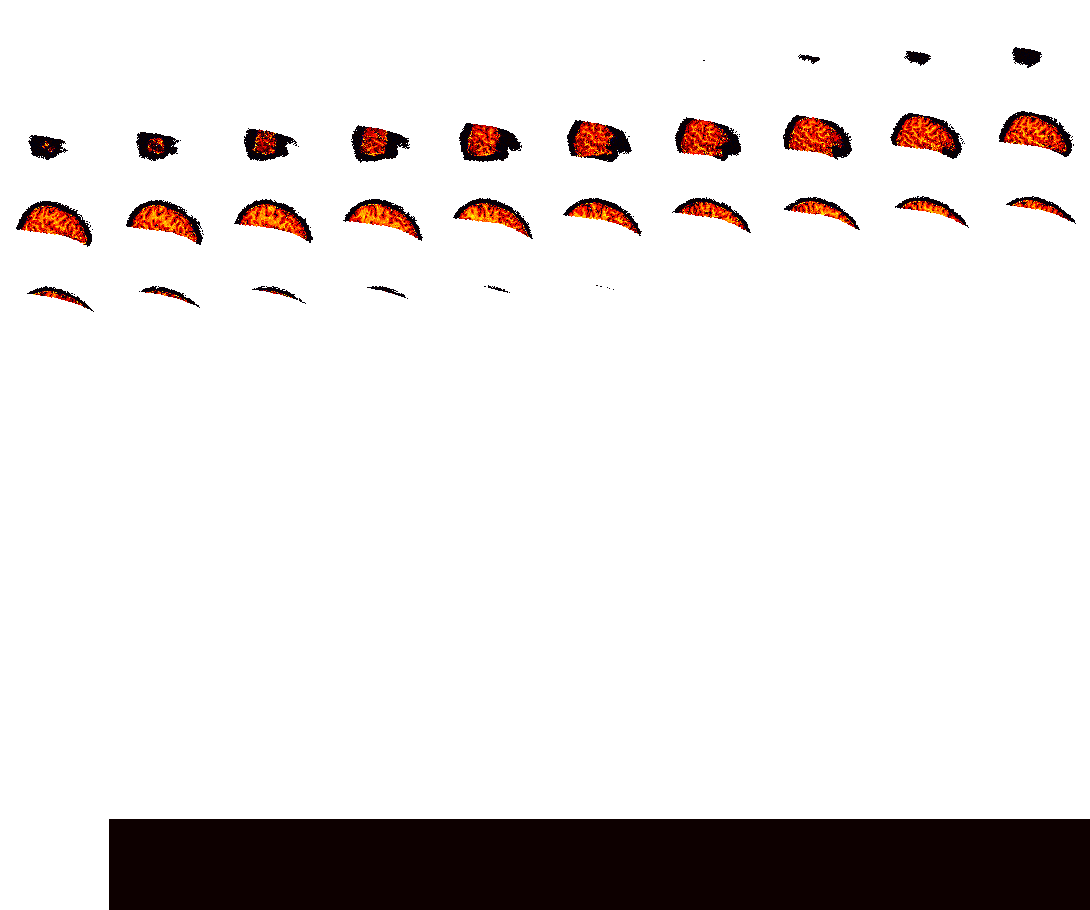

In [147]:
niplt.view_img(t123depi_data['t1w_reg'])

/home/deangelis/anaconda3/envs/nighres/lib/python3.7/site-packages/nilearn/reporting/html_document.py:60: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  MAX_IMG_VIEWS_BEFORE_WARNING))



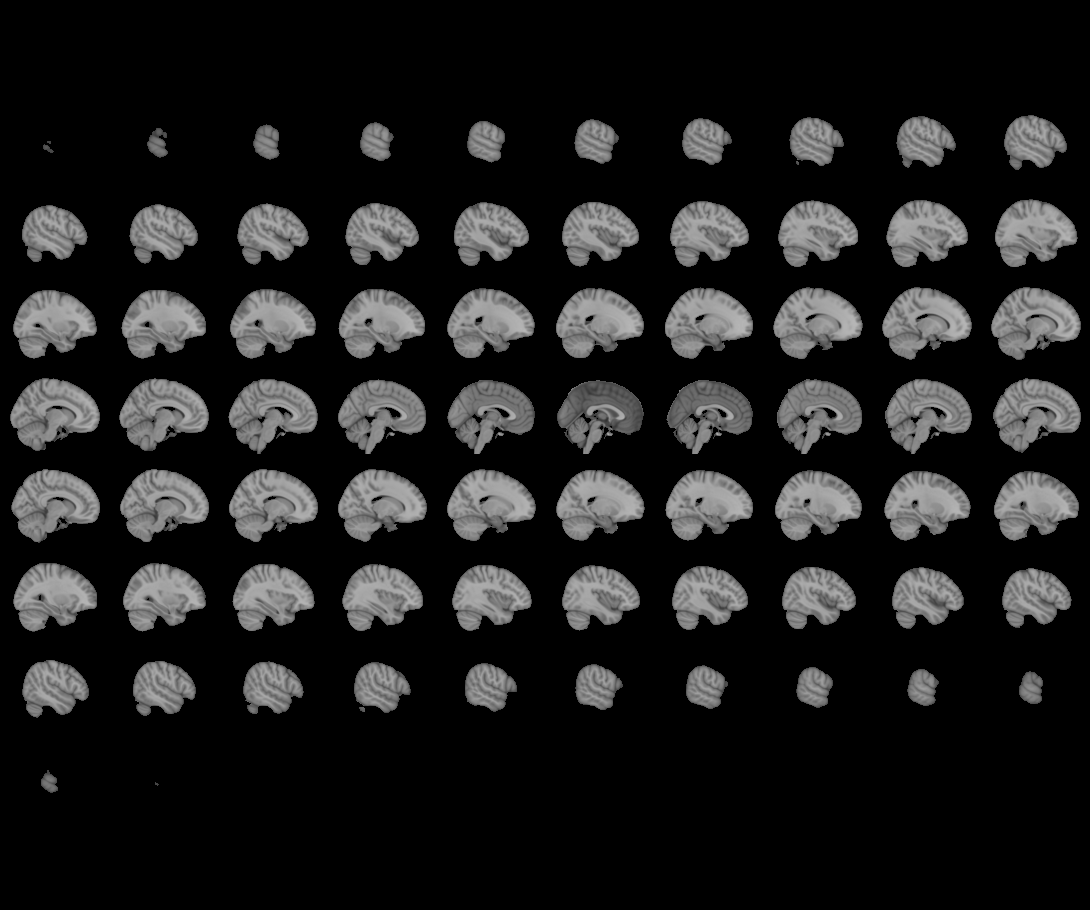
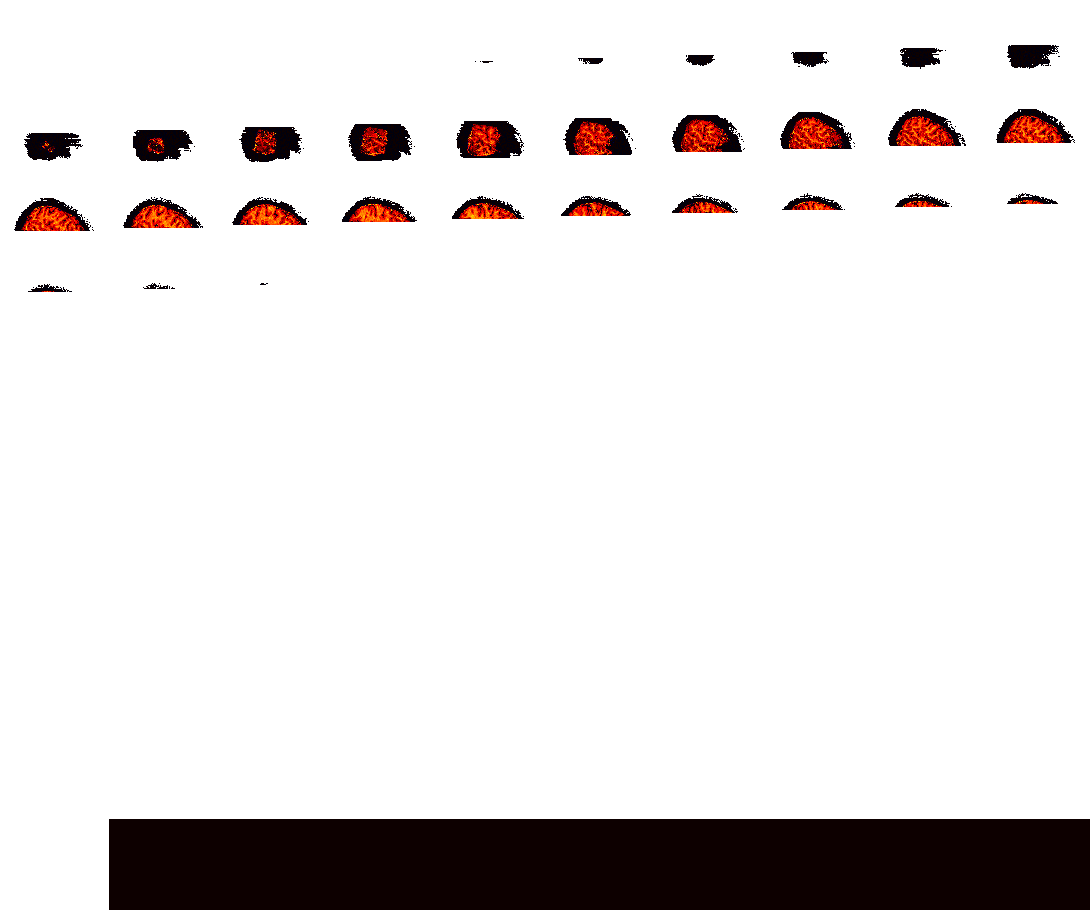

In [161]:
niplt.view_img(resampled_inv, alpha=0.3)

/home/deangelis/anaconda3/envs/nighres/lib/python3.7/site-packages/nilearn/reporting/html_document.py:60: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  MAX_IMG_VIEWS_BEFORE_WARNING))



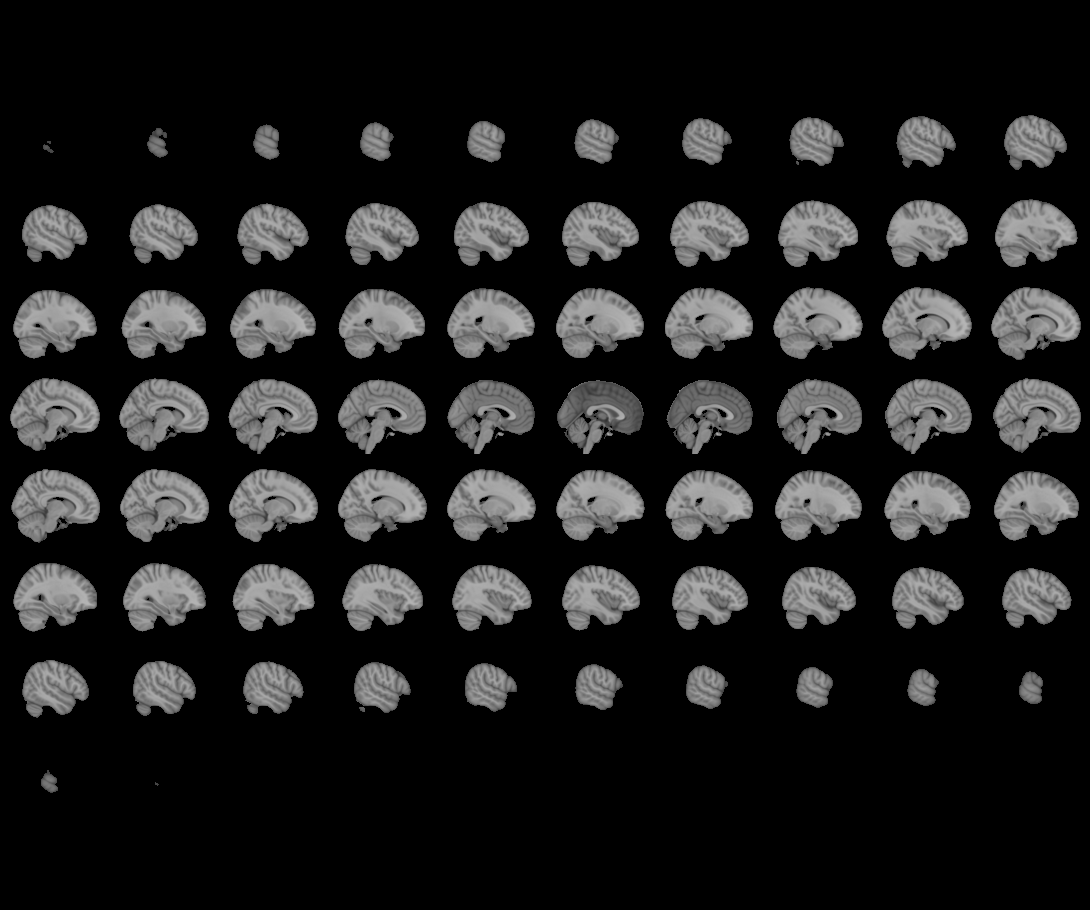
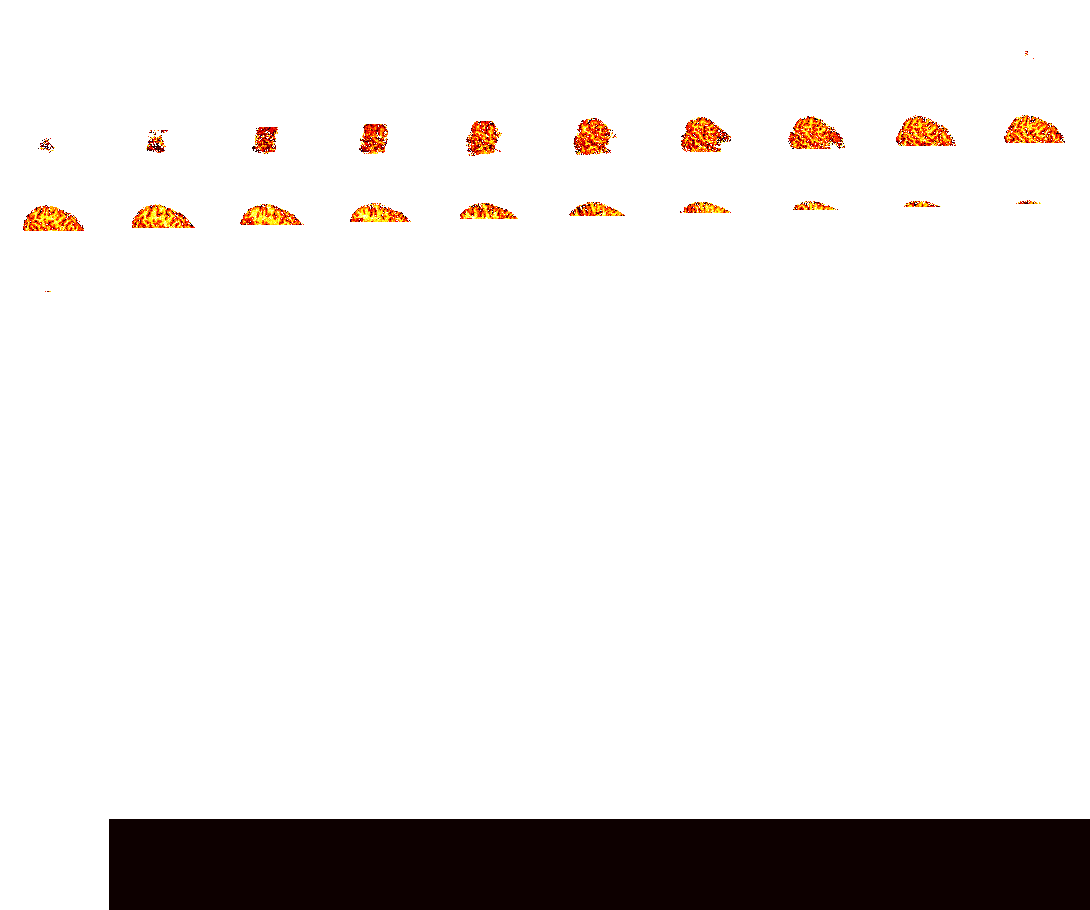

In [225]:
niplt.view_img(t123depi_data['t1w_reg'])

In [151]:
data.shape

(224, 224, 30)